In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2 
from uncertainties import ufloat
from uncertainties import unumpy
%matplotlib inline

In [2]:
# define some values 

l = 0.7e-2    # meters
p = 0.05     # xenon pressure in Torr, or 6.67 Pa
resistanceshield = ufloat(100, 5)     # ohms
resistanceplate = ufloat(10000, 500)     # ohms

In [3]:
# load in all data for set 2, make sure everything is in volts
# note: we removed the first data point of each forward set, as later on we must calculate sqrt(V - Vs) and Vs > V for the first data point

# room temperature forward
V = np.loadtxt('/data/Set2/V.txt')[1:]
roomVsload = (0.001)*np.loadtxt('/data/Set2/RVs.txt')[1:]
roomVserrload = (0.001)*np.loadtxt('/data/Set2/RVserr.txt')[1:]
roomVpload = (0.001)*np.loadtxt('/data/Set2/RVp.txt')[1:]
roomVperrload = (0.001)*np.loadtxt('/data/Set2/RVperr.txt')[1:]

# frozen out forward
frozenVsload = (0.001)*np.loadtxt('/data/Set2/FVs.txt')[1:]
frozenVserrload = (0.001)*np.loadtxt('/data/Set2/FVserr.txt')[1:]
frozenVpload = (0.001)*np.loadtxt('/data/Set2/FVp.txt')[1:]
frozenVperrload = (0.001)*np.loadtxt('/data/Set2/FVperr.txt')[1:]

# reverse data
reverseV = np.loadtxt('/data/Set2/Vrev.txt')
reverseVabs = np.loadtxt('/data/Set2/Vrevabs.txt')
reverseVsload = (0.001)*np.loadtxt('/data/Set2/Vsrev.txt')
reverseVserrload = (0.001)*np.loadtxt('/data/Set2/Vsreverr.txt')
reverseVpload = (0.001)*np.loadtxt('/data/Set2/Vprev.txt')
reverseVperrload = (0.001)*np.loadtxt('/data/Set2/Vpreverr.txt')

In [4]:
# apply uncertainties package to combine voltages and their error
roomVs = unumpy.uarray(roomVsload, roomVserrload)
roomVp = unumpy.uarray(roomVpload, roomVperrload)
frozenVs = unumpy.uarray(frozenVsload, frozenVserrload)
frozenVp = unumpy.uarray(frozenVpload, frozenVperrload)
reverseVs = unumpy.uarray(reverseVsload, reverseVserrload)
reverseVp = unumpy.uarray(reverseVpload, reverseVperrload)

In [5]:
# define functions

# current
def current(V, R):
    return V/R

# probability of scattering
def Pscatt(RIp, FIp, RIs, FIs):
    return 1 - (RIp*FIs)/(RIs*FIp)

# electron momentum
def em(V, Vs, Vc, Ve):
    return unumpy.sqrt(V - Vs + Vc + Ve)

# mean free path
def mfp(P):
    return -l/unumpy.log(1-P)

# correction potentials
def Vcontact(slope1, y1, slope2, y2):
    return (y1-y2)/(slope2-slope1)
def Vthermionic(slope):
    return 3/(2*slope)

# elastic probability of scattering
def Pelastic(P):
    return -p/l*unumpy.log(1-P)

# to reduce notation
def Value(v):
    return unumpy.nominal_values(v)
def Error(v):
    return unumpy.std_devs(v)

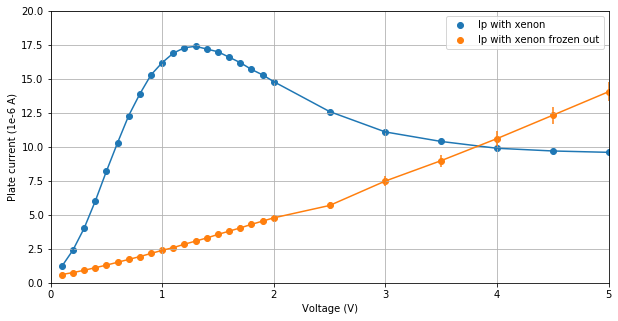

In [6]:
# Graph 1

roomIp = current(roomVp, resistanceplate)
frozenIp = current(frozenVp, resistanceplate)

plt.figure(figsize = (10,5))
plt.errorbar(V, 10*Value(roomIp)*(1e6), yerr = Error(roomIp)*(1e6))   # multiply by 10 to get graph similar in manual
plt.scatter(V, 10*Value(roomIp)*(1e6), label = 'Ip with xenon')
plt.errorbar(V, Value(frozenIp)*(1e6), yerr = Error(frozenIp)*(1e6))
plt.scatter(V, Value(frozenIp)*(1e6), label = 'Ip with xenon frozen out')
plt.ylabel('Plate current (1e-6 A)')
plt.xlabel('Voltage (V)')
plt.xlim(0,5)
plt.ylim(0,20)
plt.legend()
plt.grid();

Minimum scattering probability occurs at 0.824257+/-0.000006 sqrt(V)


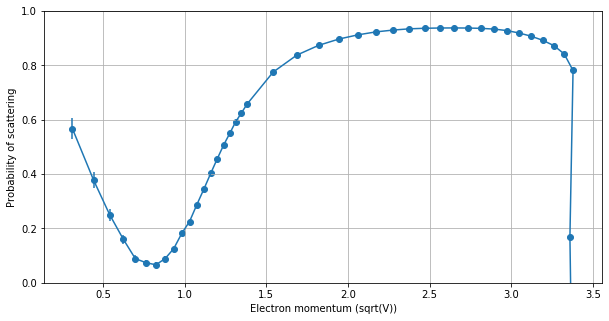

In [7]:
# Graph 2

roomIs = current(roomVs, resistanceshield)
frozenIs = current(frozenVs, resistanceshield)

# probability of scattering
Ps = Pscatt(roomIp, frozenIp, roomIs, frozenIs)

# electron momentum
emomentum = em(V, roomVs, 0, 0)     # Vc and Ve are not considered yet

plt.figure(figsize = (10,5))
plt.errorbar(Value(emomentum), Value(Ps), xerr = Error(emomentum), yerr = Error(Ps))
plt.scatter(Value(emomentum), Value(Ps))
plt.ylabel('Probability of scattering')
plt.xlabel('Electron momentum (sqrt(V))')
print('Minimum scattering probability occurs at ' f'{emomentum[6]} sqrt(V)')
plt.ylim(0,1)
plt.grid();   # ionisation occurs around x=3.3/3.4

Maximum mean free path length occurs at 0.102+/-0.016 m


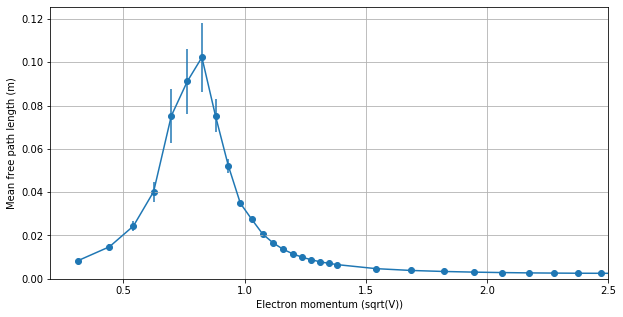

In [8]:
# inital mean free path values

mfp1 = mfp(Ps)

plt.figure(figsize = (10,5))
plt.errorbar(Value(emomentum), Value(mfp1), xerr = Error(emomentum), yerr = Error(mfp1))
plt.scatter(Value(emomentum), Value(mfp1))
plt.ylabel('Mean free path length (m)')
plt.xlabel('Electron momentum (sqrt(V))')
print('Maximum mean free path length occurs at ' f'{mfp1[6]} m')
plt.xlim(0.2,2.5)
plt.ylim(0,)
plt.grid();

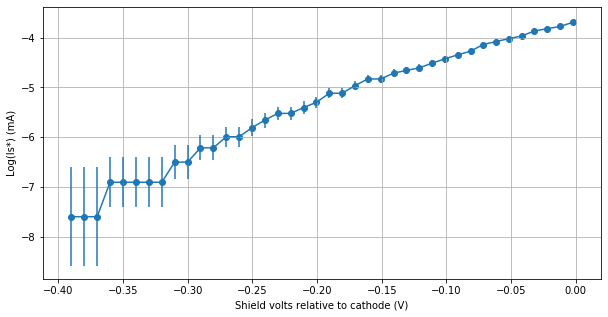

In [9]:
# Graph 3
# work in mA

reverseIs1 = current((1e3)*reverseVs[:40], resistanceshield)   # remove data points with 0 Vs to allow for log calculation
logreverseIs1 = unumpy.log(reverseIs1)

plt.figure(figsize = (10,5))
plt.errorbar(reverseV[:40]-Value(reverseVs[:40]), Value(logreverseIs1), xerr = Error(reverseVs[:40]), yerr = Error(logreverseIs1))
plt.scatter(reverseV[:40]-Value(reverseVs[:40]), Value(logreverseIs1))
plt.ylabel('Log(Is*) (mA)')
plt.xlabel('Shield volts relative to cathode (V)')
plt.grid();

In [10]:
# average of 3 and 5 points on same y level

remove = reverseVs[:40]
remove = np.delete(remove, 39)
remove = np.delete(remove, 37)
remove = np.delete(remove, 36)
remove = np.delete(remove, 35)
remove = np.delete(remove, 33)
remove = np.delete(remove, 32)

a = Value(remove)
b = Value(remove)

d = reverseV[:40]
d = np.delete(d, 39)
d = np.delete(d, 37)
d = np.delete(d, 36)
d = np.delete(d, 35)
d = np.delete(d, 33)
d = np.delete(d, 32)

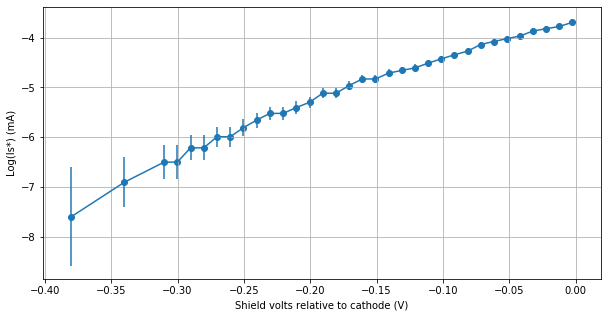

In [11]:
# Graph 3 with recurring points filtered out

reverseIs = current((1e3)*remove, resistanceshield)   
logreverseIs = unumpy.log(reverseIs)

plt.figure(figsize = (10,5))
plt.errorbar(d-a, Value(logreverseIs), xerr = b, yerr = Error(logreverseIs))
plt.scatter(d-a, Value(logreverseIs))
plt.ylabel('Log(Is*) (mA)')
plt.xlabel('Shield volts relative to cathode (V)')
plt.grid();

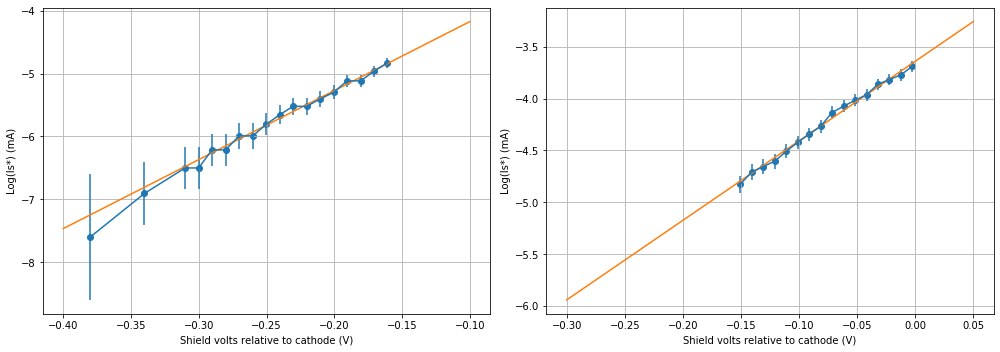

In [12]:
# finding Vc and Ve from graph 3

def func(x, m, c):
    return m*x + c

# index which splits the data into two sets, manipulate and apply to chi squared test to determine best linear fits
index = 16

logreverseIs1 = logreverseIs[index:]
logreverseIs2 = logreverseIs[:index]

mguess1 = 10
cguess1 = -3.5
mguess2 = 9
cguess2 = -3.5

x1 = np.linspace(-0.4,-0.1,1000)
x2 = np.linspace(-0.3,0.05,1000)
guess1 = np.array([mguess1,cguess1])   # manipulate until a good estimate for line parameters has been found
guess2 = np.array([mguess2,cguess2])
popt1, pcov1 = curve_fit(func, d[index:] - a[index:], Value(logreverseIs1), p0 = guess1, sigma = Error(logreverseIs1), absolute_sigma = False)
popt2, pcov2 = curve_fit(func, d[:index] - a[:index], Value(logreverseIs2), p0 = guess2, sigma = Error(logreverseIs2), absolute_sigma = False)
yfit1 = func(x1, popt1[0], popt1[1])
yfit2 = func(x2, popt2[0], popt2[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5)) 

ax1.errorbar(d[index:] - a[index:], Value(logreverseIs1), xerr = b[index:], yerr = Error(logreverseIs1))
ax1.scatter(d[index:] - a[index:], Value(logreverseIs1)) 
#ax1.plot(x1,func(x1,mguess1,cguess1))
ax1.plot(x1, yfit1)
ax1.set(ylabel = 'Log(Is*) (mA)', xlabel = 'Shield volts relative to cathode (V)') 

ax2.errorbar(d[:index] - a[:index], Value(logreverseIs2), xerr = b[:index], yerr = Error(logreverseIs2))
ax2.scatter(d[:index] - a[:index], Value(logreverseIs2)) 
#ax2.plot(x2,func(x2,mguess2,cguess2))
ax2.plot(x2, yfit2)
ax2.set(ylabel = 'Log(Is*) (mA)', xlabel = 'Shield volts relative to cathode (V)') 

plt.tight_layout()

ax1.grid()
ax2.grid();

In [13]:
# Solution for calculating χ2 sum, reduced χ2 and χ2 P-value for function 1

def chi2func1(x, y, yerr):
    yexpected = func(x, popt1[0], popt1[1])
    return np.sum(np.square((y - yexpected)/yerr))

a1 = chi2func1(d[index:] - a[index:], Value(logreverseIs1), Error(logreverseIs1))   # chi2 value
v1 = len(logreverseIs1) - 2   # number of constraints = 2
rchi21 = a1/v1   # reduced chi2 value
P1=chi2.sf(a1, v1)  # P value

print('chi2=' ,a1)
print('reduced chi2=' ,rchi21)
print('P-value=' ,P1)

chi2= 1.8815962541178701
reduced chi2= 0.11759976588236688
P-value= 0.9999933740002959


In [14]:
# Solution for calculating χ2 sum, reduced χ2 and χ2 P-value for function 2

def chi2func2(x, y, yerr):
    yexpected = func(x, popt2[0], popt2[1])
    return np.sum(np.square((y - yexpected)/yerr))

a2 = chi2func2(d[:index] - a[:index], Value(logreverseIs2), Error(logreverseIs2))   # chi2 value
v2 = len(logreverseIs2) - 2   # number of constraints = 2
rchi22 = a2/v2   # reduced chi2 value
P2 = chi2.sf(a2, v2)  # P value

print('chi2=' ,a2)
print('reduced chi2=' ,rchi22)
print('P-value=' ,P2)

chi2= 2.937678189896898
reduced chi2= 0.209834156421207
P-value= 0.999178976122259


V thermionic= 0.137+/-0.004 V
V contact= -0.171+/-0.025 V


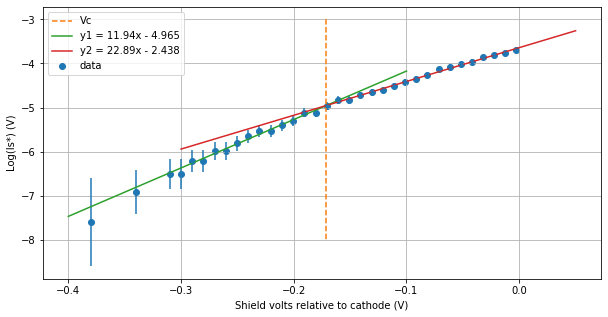

In [15]:
# finding Vc and Ve and visualising it

# define slope and intercept and their uncertainties
m1 = ufloat(popt1[0], np.sqrt(pcov1[0,0]))
c1 = ufloat(popt1[1], np.sqrt(pcov1[1,1]))
m2 = ufloat(popt2[0], np.sqrt(pcov2[0,0]))
c2 = ufloat(popt2[1], np.sqrt(pcov2[1,1]))

Vc = np.abs(Vcontact(m1, c1, m2, c2))     # intersection of our two lines
Ve = np.abs(Vthermionic(m1))

plt.figure(figsize = (10,5))
plt.errorbar(d - a, Value(logreverseIs), xerr = b, fmt = '.', yerr = Error(logreverseIs))
plt.scatter(d - a, Value(logreverseIs), label = 'data')
plt.plot(-Value(Vc)*np.ones(1000), np.linspace(-3, -8, 1000), '--', label = 'Vc')
plt.plot(x1, yfit1, label = 'y1 = 11.94x - 4.965')
plt.plot(x2, yfit2, label = 'y2 = 22.89x - 2.438')
plt.ylabel('Log(Is*) (V)')
plt.xlabel('Shield volts relative to cathode (V)')
plt.grid()
plt.legend()

print('V thermionic= ' f'{Ve} V')
print('V contact= ' f'{-Vc} V');

Minimum scattering probability occurs at 0.993+/-0.014 sqrt(V)


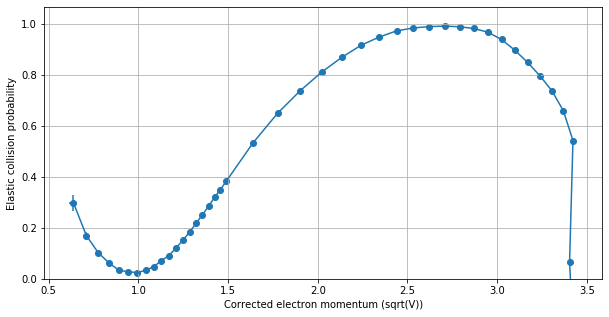

In [16]:
# Graph 4

Pc = (1/20)*Pelastic(Ps)    #normalise
emomentumfinal = em(V, roomVs, Vc, Ve)

plt.figure(figsize = (10,5))
plt.errorbar(Value(emomentumfinal), Value(Pc), xerr = Error(emomentumfinal), yerr = Error(Pc))
plt.scatter(Value(emomentumfinal), Value(Pc))
plt.ylabel('Elastic collision probability')
plt.xlabel('Corrected electron momentum (sqrt(V))')
print('Minimum scattering probability occurs at ' f'{emomentumfinal[6]} sqrt(V)')
plt.grid()
plt.xlim()
plt.ylim(0,);

Max mean free path length occurs at 0.102+/-0.016 m


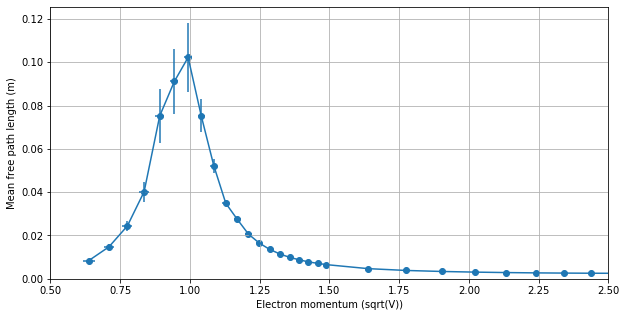

In [17]:
# mean free path values with corrected momentum

plt.figure(figsize = (10,5))
plt.errorbar(Value(emomentumfinal), Value(mfp1), xerr = Error(emomentumfinal), yerr = Error(mfp1))
plt.scatter(Value(emomentumfinal), Value(mfp1))
plt.ylabel('Mean free path length (m)')
plt.xlabel('Electron momentum (sqrt(V))')
print('Max mean free path length occurs at ' f'{mfp1[6]} m')
plt.grid()
plt.ylim(0,)
plt.xlim(0.5,2.5);